In [1]:
%matplotlib inline
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import math

Loading training data.

In [2]:
IMAGE_SIZE = 20
train_data = io.loadmat('ex4data1.mat')
X = np.insert(train_data['X'], 0, 1, axis=1) # add bias column at the beginning of X
y = train_data['y']
y[y==10]=0 # convert matlab index to python index

Visual training data.

In [3]:
def display_data(data):
    m,n = data.shape
    row_width = int(np.sqrt(m))
    img_width = img_height = int(np.sqrt(n))
    img_show = np.empty((row_width*img_width, img_width*row_width))
    for i in range(row_width):
        for j in range(row_width):
            img_show[img_height*i:(img_height*i)+img_height, img_width*j:img_width*j + img_width] = \
            np.reshape(data[i*row_width + j, :], (img_height, img_width), order='F')
            
    plt.imshow(img_show)

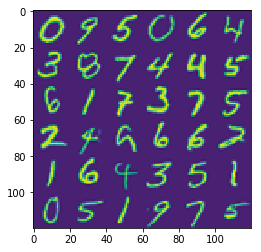

In [4]:
idx = np.random.randint(X.shape[0], size=36)
display_data(X[idx, 1:])

Implement sigmoid activation function.

In [5]:
def sigmoid(value):
    return 1 / (1 + math.e ** (-value))

Compute feedfoward prediction, our neural network have 3 layout: 1 input, 1 hidden and 1 output layout.
So we will have 2 weight matrix that need to update: W1 with size 25x401 mapping from input layout to hidden layout and W2 with size 10x26 mapping from hidden layout to output layout.

In [76]:
# define neural network architecture
INPUT_LAYER_SIZE = 400 # number of features 
HIDDEN_LAYER_SIZE = [25,25] # number of hidden layers and number of node in each layers
OUTPUT_LAYER_SIZE = 10 # number of output layers

In [7]:
def randomInitialize(inputs_size, hiddens_sizes, outputs_size, epsilon=0.001):
    """
    Create all the Weights matrix for our neural network and random initialize it in range [-epsilon -> epsilon].
    Return one big vector contains all the unroll Weights matrix.
    
    Input : inputs_size   (int)    : number of features
            hiddens_sizes (list)   : a list contain the number of node in each hidden layer
            outputs_size  (int)    : number of node in the output layer
            epsilon       (float)  : initialize value range of Neural Network Weights
            
    Output : Ws_unroll    (ndarray): vector contain the unroll Neural Network Weights
    """
    num_Weights = 0
    previousLayerSize = inputs_size
    not_input_layers = [x for x in HIDDEN_LAYER_SIZE]
    not_input_layers.append(outputs_size)
    Ws = []
    for currentLayerSize in not_input_layers:
        num_Weights += currentLayerSize * (previousLayerSize+1)
        Ws.append(np.random.uniform(-epsilon, epsilon, (currentLayerSize * (previousLayerSize+1), 1)))
        previousLayerSize = currentLayerSize
    
    Ws_unroll = np.concatenate(Ws)
    
    return Ws_unroll

In [9]:
def extractWeights(Ws_unroll):
    """
    Recreate Neural Network Weights from Unroll Weights base on Neural Network Architecture.
    Input :  Ws_unroll (ndarray) : big Weights vector need to be extract
    Output:  Ws        (list)    : list of Weights correctspond to each layer of neural network
    """
     # Reshape Ws to bring Weight matrices back to it original
    not_input_layers = [x for x in HIDDEN_LAYER_SIZE]
    not_input_layers.append(OUTPUT_LAYER_SIZE)
    
    Ws = []
    previous_layer_size = INPUT_LAYER_SIZE
    current_weight_size = 0
    for layer_size in not_input_layers:
        layer_num_node = layer_size * (previous_layer_size+1)
        Ws.append(np.reshape(Ws_unroll[current_weight_size:current_weight_size+layer_num_node], (layer_size, previous_layer_size+1)))
        current_weight_size += layer_num_node
        previous_layer_size = layer_size   
    
    return Ws

In [18]:
def feedforward(X, Ws_unroll):
    """
    Compute output layer of neural network
    Input  : X (ndarray)  : training examples
             Ws_unroll (ndarray) : Weights of neural network in one big vector form
            
    Output : a  (ndarray) : output layer with respect to X
    """
    
    Ws = extractWeights(Ws_unroll)
    
    # Start feedforward algorithms
    a = X
    for i, W in enumerate(Ws):
        z = np.dot(W, a.T)
        a = sigmoid(z.T)
        if(i != (len(Ws)) - 1) : # not output layer
            a = np.insert(a, 0, 1, axis=1)

    return a

Transform y from vector to big Y matrix contains only 0 and 1, where each row now is not a number but a vector.
If $x^{i}$ is correctsponding to the number 5  then $y^{i}$ would be a vector where $y_i$ = 1 and the rest is 0

In [11]:
Y = np.zeros((y.shape[0], OUTPUT_LAYER_SIZE))
for i in range(OUTPUT_LAYER_SIZE):
    Y[np.where(y==i)[0], i] = 1

Compute neural network cost function

In [12]:
def nnRegularization(Ws_unroll, m, _lambda):
    """
    Compute the regularization term of neural network cost function
    Input  : Ws_unroll (ndarray)   : Weights of neural network in one big vector form
             m          (int)      : number of training examples in data set
             _lambda      (number) : value control how we want to penalize our weights,
                                     if _lambda is big it mean we want 
                                     the value of all the weights in our network is pretty small, prevent overfitting
    Output : Reg       (float)     : Value of regularization term 
    """
    
    Reg = 0
    Ws = extractWeights(Ws_unroll)
    
    for w in Ws:
        Reg += np.dot(w[:, 1:].ravel().T, w[:, 1:].ravel())
        
    Reg *= (_lambda / (2*m))
    
    return Reg

In [16]:
def nnCostFunction(Ws_unroll, X, Y, _lambda=0):
    """
    Compute neural network model cost function
    Input:   Ws_unroll (ndarray) : Weights of neural network in one big vector form
             X (ndarray)         : training set
             Y (ndarray)         : training set label
             _lambda (float)     : value of regularize term
             
    Output:  Cost    (float)     : Cost of neural network base on training set (X,Y) with respect to Weights Ws_unroll
    """
    m,_ = X.shape
    NUM_LABELS = Y.shape[1]
    h_x = feedforward(X, Ws_unroll)
    
    Cost = 0
    for i in range(NUM_LABELS):
        Cost += -np.dot(Y[:,[i]].T, np.log(h_x[:,[i]])) - np.dot((1-Y[:,[i]]).T, np.log(1 - h_x[:,[i]]) )
    Cost /= m
    Cost += nnRegularization(Ws_unroll, m, _lambda)
    
    return Cost

Compute derivative of sigmoid activation function

In [33]:
def sigmoidGradient(z):
    return sigmoid(z) * (1 - sigmoid(z))

Compute partial derivative of all the Weights in out neural network model using back propagation algorithm

In [118]:
def backPropagation(Ws_Unroll, X, Y, alpha=1, _lambda=0):
    """
    Compute the gradient of our Neural network model using back propagation algorithm.
    Input : Ws_Unroll (ndarray) : Current Weights of neural network need to compute gradient
            X (ndarray)         : Training Example in Training set
            Y (ndarray)         : Training Labels in Training set
            alpha (float)       : value of learning rate
            _lambda (float)     : value of regularize term
            
    Output: Ws_grad_unroll (ndarray) : big vector contains all the gradient of neural network with respect to Ws_unroll
    """
    
    m,n = X.shape
    Ws = extractWeights(Ws_Unroll)
    # Start feedforward algorithms
    _a = [0] * (len(HIDDEN_LAYER_SIZE) + 2) # create _a with number element equal number of layers
    _z = [0] * (len(HIDDEN_LAYER_SIZE) + 2) # create _z with number element equal number of layers
    _a[0] = X
    for i, W in enumerate(Ws):
        z = np.dot(W, _a[i].T)
        _z[i+1] = z
        a = sigmoid(z.T)
        if(i != (len(Ws)) - 1) : # not output layer
            a = np.insert(a, 0, 1, axis=1)
        _a[i+1]= a
        
        
    _delta = [0]  * (len(HIDDEN_LAYER_SIZE) + 1)  # _delta hold error term for each layers except input layer
    _delta[-1] = _a[-1] - Y # H - Y
    
    for i in range(len(HIDDEN_LAYER_SIZE), 0, -1):
        _delta[i-1] = np.dot(_delta[i], Ws[i][:,1:]) * sigmoidGradient(_z[i].T)
    
    W_grads = []
    for i in range(len(_delta)):
        grad = np.dot(_delta[i].T, _a[i]) * (alpha/m)
        grad[:,1:] += grad[:,1:] * (_lambda / m)
        grad_unroll = grad.ravel()
        W_grads.append(np.reshape(grad_unroll, (grad_unroll.shape[0], 1)))
        
    W_grad_unroll = np.concatenate(W_grads)
    
    return W_grad_unroll

In [75]:
def backPropagation_3layers(Weights, X, Y, alpha=1, _lambda=0):
    """
    Return a list with same size with Weights,
    Each element is the partial derivative term of Neural network cost function with respect to the each weights.
    """
    
    m,n = X.shape
    a1 = X
    z2 = np.dot(Weights[0], a1.T)
    a2 = sigmoid(z2.T)
    a2 = np.insert(a2, 0, 1, axis=1)
    z3 = np.dot(Weights[1], a2.T)
    h = sigmoid(z3.T)
    
    delta3 = h - Y
    delta2 = np.dot(delta3, Weights[1][:,1:]) * sigmoidGradient(z2.T)
    
    W2_grad = np.dot(delta3.T, a2) * (alpha/m)
    W1_grad = np.dot(delta2.T, X)  * (alpha/m)
    
    W1_grad[:,1:] += W1_grad[:,1:] * (_lambda / m)
    W2_grad[:,1:] += W2_grad[:,1:] * (_lambda / m)
#     print(W2_grad)
    return [W1_grad, W2_grad]


Start training our neural network using mini batch gradient descent

In [122]:
def trainNN(Weights, X, Y, alpha=1, _lambda=0, batch_size=5000, stochastic_loop=1):
    m,n = X.shape
    
    for loop in range(stochastic_loop):
        for i in range(0, m, batch_size):
            W_grads = backPropagation(Weights, X[i:i+batch_size], Y[i:i+batch_size], alpha, _lambda)
            Weights -= W_grads
           
        print('Iteration %d - Cost : %s' %  ( loop, str(nnCostFunction(Weights, X, Y, _lambda))), end='\r')
    return Weights

In [150]:
Weights = randomInitialize(INPUT_LAYER_SIZE, HIDDEN_LAYER_SIZE, OUTPUT_LAYER_SIZE)

In [165]:
Weights = trainNN(Weights, X, Y, alpha=0.1, _lambda=1, batch_size=512, stochastic_loop=100)

Compute accuracy of our model on data set

In [126]:
def predict(Weights, X):
    hx = feedforward(X, Weights)
    m,_ = X.shape
    predict = np.argmax(hx, axis=1).reshape((m, 1))
    
    return predict

In [169]:
def score(Weights, X, y):
    m,_ = X.shape
    return sum(predict(Weights, X)==y) /m

In [170]:
score(Weights, X, y)

array([ 0.9954])